# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [74]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [75]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 16, 22, 26, 2, 176714)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [83]:
# os.environ["HOPSWORKS_API_KEY"] = ""

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1160344
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [84]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [94]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=4,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [95]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.581654E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [96]:
# Access the feature names of the trained XGBoost model
feature_names = retrieved_xgboost_model.get_booster().feature_names

# Print the feature names
print("Feature names:", feature_names)


Feature names: ['past_air_quality', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']


## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [97]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
today_timestamp = pd.to_datetime(today)
batch_data = weather_fg.filter(weather_fg.date >= today_timestamp ).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.89s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-21 00:00:00+00:00,21.000000,0.0,6.696387,53.746078,lahore
1,2024-11-20 00:00:00+00:00,20.950001,0.0,2.305125,308.659821,lahore
2,2024-11-17 00:00:00+00:00,21.250000,0.0,4.334974,274.763550,lahore
3,2024-11-22 00:00:00+00:00,22.799999,0.0,5.483356,66.801384,lahore
4,2024-11-25 00:00:00+00:00,20.600000,0.0,5.400000,323.130035,lahore
5,2024-11-24 00:00:00+00:00,22.200001,0.0,7.594207,5.440250,lahore
6,2024-11-23 00:00:00+00:00,22.299999,0.0,6.151683,20.556128,lahore
7,2024-11-19 00:00:00+00:00,20.799999,0.0,7.235910,275.710510,lahore
8,2024-11-18 00:00:00+00:00,21.150000,0.0,5.804825,277.124908,lahore


### Get Mean air quality for past days

In [98]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
selected_features = air_quality_fg.select_all() #(['pm25']).join(weather_fg.select_all(), on=['city'])
selected_features = selected_features.read()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.10s) 


In [99]:
selected_features = selected_features.sort_values(by='date').reset_index(drop=True)

In [112]:
past_air_q_list = selected_features[['date', 'pm25']][-3:]['pm25'].tolist()

In [101]:
batch_data = batch_data.sort_values(by='date').reset_index(drop=True)

In [102]:
batch_data['past_air_quality'] = None

In [104]:
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,past_air_quality
0,2024-11-17 00:00:00+00:00,21.250000,0.0,4.334974,274.763550,lahore,194.516663
1,2024-11-18 00:00:00+00:00,21.150000,0.0,5.804825,277.124908,lahore,None
2,2024-11-19 00:00:00+00:00,20.799999,0.0,7.235910,275.710510,lahore,None
3,2024-11-20 00:00:00+00:00,20.950001,0.0,2.305125,308.659821,lahore,None
4,2024-11-21 00:00:00+00:00,21.000000,0.0,6.696387,53.746078,lahore,None
5,2024-11-22 00:00:00+00:00,22.799999,0.0,5.483356,66.801384,lahore,None
6,2024-11-23 00:00:00+00:00,22.299999,0.0,6.151683,20.556128,lahore,None
7,2024-11-24 00:00:00+00:00,22.200001,0.0,7.594207,5.440250,lahore,None
8,2024-11-25 00:00:00+00:00,20.600000,0.0,5.400000,323.130035,lahore,None


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [121]:
# Initialize an empty list to store predictions
predictions = []

# Iterate through each row of the DataFrame
for index, row in batch_data.iterrows():
    past_air_quality_mean = sum(past_air_q_list)/3
    # Extract the feature values for prediction as a 1D array
    features = row[['past_air_quality', 'temperature_2m_mean', 'precipitation_sum', 
                    'wind_speed_10m_max', 'wind_direction_10m_dominant']].values
    
    # Reshape features to a 2D array (required by XGBoost's predict method)
    features = features.reshape(1, -1)
    
    # Make a prediction for the row
    prediction = retrieved_xgboost_model.predict(features)
    
    # Append the prediction to the list
    predictions.append(prediction[0])
    past_air_q_list.append(prediction[0])
    past_air_q_list = past_air_q_list[1:]

    # print(past_air_q_list)
    batch_data.loc[index,'past_air_quality'] = past_air_quality_mean

# Add the predictions as a new column in the DataFrame
batch_data['predicted_pm25'] = predictions

# Display the updated DataFrame
batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,past_air_quality,predicted_pm25
0,2024-11-17 00:00:00+00:00,21.250000,0.0,4.334974,274.763550,lahore,192.615718,188.886642
1,2024-11-18 00:00:00+00:00,21.150000,0.0,5.804825,277.124908,lahore,193.45164,188.886642
2,2024-11-19 00:00:00+00:00,20.799999,0.0,7.235910,275.710510,lahore,195.333527,169.527344
3,2024-11-20 00:00:00+00:00,20.950001,0.0,2.305125,308.659821,lahore,182.433543,176.911346
4,2024-11-21 00:00:00+00:00,21.000000,0.0,6.696387,53.746078,lahore,178.441778,163.270782
5,2024-11-22 00:00:00+00:00,22.799999,0.0,5.483356,66.801384,lahore,169.903158,175.669861
6,2024-11-23 00:00:00+00:00,22.299999,0.0,6.151683,20.556128,lahore,171.950663,166.032242
7,2024-11-24 00:00:00+00:00,22.200001,0.0,7.594207,5.440250,lahore,168.324295,167.821014
8,2024-11-25 00:00:00+00:00,20.600000,0.0,5.400000,323.130035,lahore,169.841039,194.360626


In [122]:
# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#     batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
# batch_data

In [123]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   past_air_quality             9 non-null      object             
 7   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(2)
memory usage: 524.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [124]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data['date'] = batch_data['date'].dt.tz_convert(None).astype('datetime64[ns]')
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,past_air_quality,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-17,21.250000,0.0,4.334974,274.763550,lahore,192.615718,188.886642,pakistan-lahore-cantonment,pakistan,1
1,2024-11-18,21.150000,0.0,5.804825,277.124908,lahore,193.45164,188.886642,pakistan-lahore-cantonment,pakistan,2
2,2024-11-19,20.799999,0.0,7.235910,275.710510,lahore,195.333527,169.527344,pakistan-lahore-cantonment,pakistan,3
3,2024-11-20,20.950001,0.0,2.305125,308.659821,lahore,182.433543,176.911346,pakistan-lahore-cantonment,pakistan,4
4,2024-11-21,21.000000,0.0,6.696387,53.746078,lahore,178.441778,163.270782,pakistan-lahore-cantonment,pakistan,5
5,2024-11-22,22.799999,0.0,5.483356,66.801384,lahore,169.903158,175.669861,pakistan-lahore-cantonment,pakistan,6
6,2024-11-23,22.299999,0.0,6.151683,20.556128,lahore,171.950663,166.032242,pakistan-lahore-cantonment,pakistan,7
7,2024-11-24,22.200001,0.0,7.594207,5.440250,lahore,168.324295,167.821014,pakistan-lahore-cantonment,pakistan,8
8,2024-11-25,20.600000,0.0,5.400000,323.130035,lahore,169.841039,194.360626,pakistan-lahore-cantonment,pakistan,9


In [125]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         9 non-null      datetime64[ns]
 1   temperature_2m_mean          9 non-null      float32       
 2   precipitation_sum            9 non-null      float32       
 3   wind_speed_10m_max           9 non-null      float32       
 4   wind_direction_10m_dominant  9 non-null      float32       
 5   city                         9 non-null      object        
 6   past_air_quality             9 non-null      object        
 7   predicted_pm25               9 non-null      float32       
 8   street                       9 non-null      object        
 9   country                      9 non-null      object        
 10  days_before_forecast_day     9 non-null      int64         
dtypes: datetime64[ns](1), float32(5), int64(1), objec

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-16 22:51:17,935 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



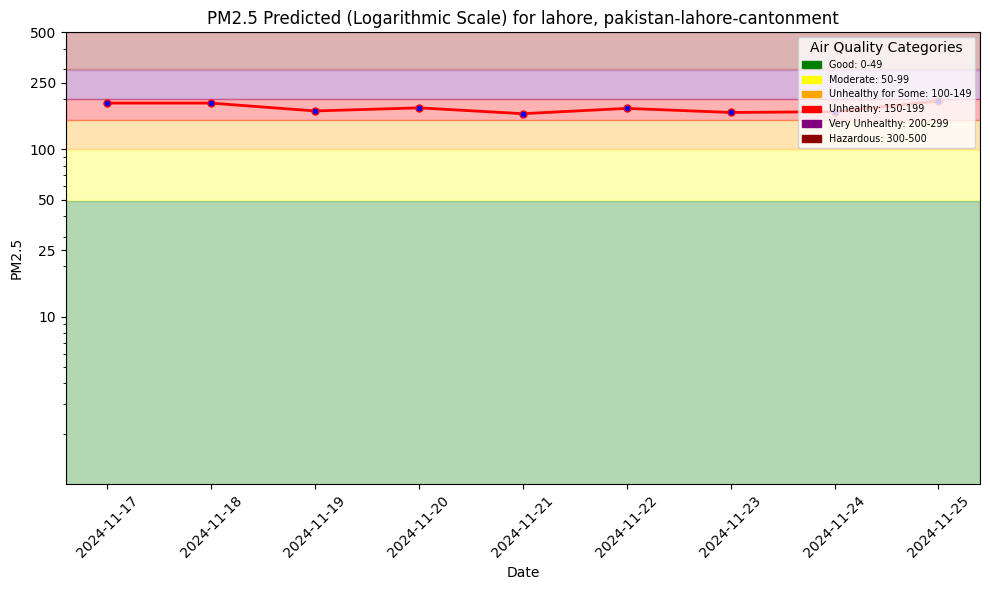

In [126]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [127]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [128]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1160344/fs/1151047/fg/1350020


Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1160344/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f8b238a8f70>, None)

In [129]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.25s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,past_air_quality,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-17 00:00:00+00:00,21.25,0.0,4.334974,274.76355,lahore,192.615718,188.886642,pakistan-lahore-cantonment,pakistan,1


In [130]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 


,date,pm25,country,city,street,url,past_air_quality
0,2020-06-17,22.120001,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,19.980000
1,2022-09-03,8.350000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,9.383334
2,2024-09-21,16.750000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,13.490000
3,2023-12-12,106.650002,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,90.556667
4,2022-04-30,33.599998,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,19.146666
...,...,...,...,...,...,...,...
1793,2020-03-29,16.600000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,19.656667
1794,2022-01-25,73.930000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,64.386668
1795,2022-02-02,45.869999,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,75.203332
1796,2021-05-31,8.250000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,10.740000


In [131]:
air_quality_df['date']

0       2020-06-17
1       2022-09-03
2       2024-09-21
3       2023-12-12
4       2022-04-30
           ...    
1793    2020-03-29
1794    2022-01-25
1795    2022-02-02
1796    2021-05-31
1797    2024-11-16
Name: date, Length: 1798, dtype: object

In [132]:
monitoring_df['date']

0   2024-11-17 00:00:00+00:00
Name: date, dtype: datetime64[us, UTC]

In [133]:
air_quality_df['date'] = pd.to_datetime(air_quality_df['date'])
monitoring_df['date'] = monitoring_df['date'].dt.tz_convert(None).astype('datetime64[ns]')

In [134]:


outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.97s) 


ValueError: feature_names mismatch: ['past_air_quality', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
expected past_air_quality in input data

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [ ]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

In [ ]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---